# A StoDynProg usage example

This document contains a step-by-step example on:

* how to to use the opensource `StoDynProg` library (https://github.com/pierre-haessig/stodynprog),
* in order to solve the *Optimal control of an Energy Storage with an AR(1) input sollicitation*.

Pierre Haessig — July 2019

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#System-description" data-toc-modified-id="System-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>System description</a></span><ul class="toc-item"><li><span><a href="#Dynamics" data-toc-modified-id="Dynamics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dynamics</a></span></li><li><span><a href="#Set-of-admissible-controls" data-toc-modified-id="Set-of-admissible-controls-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Set of admissible controls</a></span></li><li><span><a href="#Cost" data-toc-modified-id="Cost-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Cost</a></span></li><li><span><a href="#Collect-all-these-function-in-one-SysDescription-object" data-toc-modified-id="Collect-all-these-function-in-one-SysDescription-object-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Collect all these function in one <code>SysDescription</code> object</a></span></li></ul></li><li><span><a href="#Control-optimization-with-SDP" data-toc-modified-id="Control-optimization-with-SDP-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Control optimization with SDP</a></span><ul class="toc-item"><li><span><a href="#Create-a-DPSolver-object" data-toc-modified-id="Create-a-DPSolver-object-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create a <code>DPSolver</code> object</a></span></li><li><span><a href="#Policy-optimization-with-&quot;Policy-Iteration&quot;-algorithm" data-toc-modified-id="Policy-optimization-with-&quot;Policy-Iteration&quot;-algorithm-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Policy optimization with "Policy Iteration" algorithm</a></span></li></ul></li><li><span><a href="#Plot-the-energy-manangement-policy" data-toc-modified-id="Plot-the-energy-manangement-policy-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot the energy manangement policy</a></span><ul class="toc-item"><li><span><a href="#3D-plot-of-the-policy" data-toc-modified-id="3D-plot-of-the-policy-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>3D plot of the policy</a></span></li><li><span><a href="#2D-plot-of-the-policy" data-toc-modified-id="2D-plot-of-the-policy-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>2D plot of the policy</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import scipy.stats as stats

#%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## System description

Problem description overview:

![Storage management problem](app_stodynprog_files/storage_management_EN.png)

Control objective : manage the power flows (e.g. storage power $P_{sto}$) to minimize system cost (e.g. deviation penalty on $P_{dev}$) despite the random perturbation $P_{mis}$.

Power conservation equation:

$$P_{dev} = P_{mis} - P_{sto} - P_{cur} $$

Parameters of the problem

In [2]:
# time step
dt = 1. # [h]
# AR(1) input : std and correlation
p_scale = 1. # MW
p_corr = 0.8
# Storage ratings
E_rated = 10. # MWh
P_rated = 4. # MW
print('Energy storage capacity: {:.1f} MWh'.format(E_rated))

Energy storage capacity: 10.0 MWh


### Dynamics

Variables of the problem:

* 2 state variables: $E_{sto}$ (stored energy) and $P_{mis}$ (production mismatch)
* 2 control variables: $P_{sto}$ (power absorbed by the storage) and $P_{cur}$ (curtailed power)
* 1 perturbation: $w$ (innovation of the AR(1) process)

$$
\begin{split}
  E_{sto}(k+1) &=  E_{sto}(k) + P_{sto}(k) \Delta_t \\
  P_{mis}(k+1) &= \phi P_{mis}(k) + w(k)
\end{split}
$$

In [3]:
def dyn_sto(E, P_mis, P_sto, P_cur, innov):
    '''state transition function of a lossless Energy storage
    
    returns (E(k+1), P_mis(k+1))
    '''
    # 1) Stored energy evolution:
    E_next = E + P_sto*dt
    # 2) Storage request AR(1) model:
    P_mis_next = p_corr*P_mis + innov
    return (E_next, P_mis_next)

# Test:
dyn_sto(5, 2, 1, 0, 0.02)

(6.0, 1.62)

Probability law of the innovation $w(k)$

In [4]:
innov_scale = p_scale * np.sqrt(1- p_corr)
innov_law = stats.norm(loc=0, scale=innov_scale)

### Set of admissible controls

    
Contrainsts of the Energy Storage are:

1. Energy stock boundaries : $0 ≤ E(k + 1) ≤ E_{rated}$, therefore $-E(k) ≤ P_{sto}\Delta_t ≤ E_{rated}-E(k)$
2. Power limitation : $-P_{rated} ≤ P_{sto} ≤ P_{rated}$

Also, the curtailment $P_{cur}$ is constrained between $0$ and $P_{mis}$

In [5]:
curt_activ = False

def admissible_controls(E, P_mis):
    '''set of admissible control U(x_k) of an Energy storage
    The two controls are P_sto and P_cur.

    ''' 
    # 1) Constraints on P_sto:
    P_neg = np.max((           -E /dt, -P_rated))
    P_pos = np.min(( (E_rated - E)/dt, +P_rated))
    U1 = (P_neg, P_pos)

    # 2) Constraints on the curtailment P_cur
    if curt_activ:
        U2 = (0, np.max((P_mis,0)) )
    else: # disable curtailment
        U2 = (0,0)
    return (U1, U2)

# Test:
admissible_controls(2, 1)

((-2.0, 4.0), (0, 0))

### Cost

Instantaneous cost function, which penalized the deviation from the grid commitment $P_{dev}$.

Here we choose a *quadratic* penalization, with a tolerance of $\pm 0.9 P_{tol}$

In [6]:
P_tol = 0.5 #MW
P_tol_reduced = 0.9 * P_tol

def cost_thres_quad(E, P_mis, P_sto, P_cur, innov):
    '''a threshold-quadratic cost model:
    c_k = (P_dev - P_tol)² if P_dev > +P_tol
          (P_dev + P_tol)² if P_dev < -P_tol
          0 otherwise
    '''
    P_dev = P_mis - P_cur - P_sto
    # Cost when P_dev is above/in/under the threshold
    c_abov  = (P_dev - P_tol_reduced)**2
    c_mid   =  0.*P_dev
    c_under = (P_dev + P_tol_reduced)**2
    # Choose the proper cost:
    cost = np.where(P_dev >  P_tol_reduced, c_abov, c_mid)
    cost = np.where(P_dev < -P_tol_reduced, c_under, cost)
    return cost

cost_thres_quad(5, 2, 1, 0, 0)

array(0.3025)

### Collect all these function in one `SysDescription` object

In [7]:
from stodynprog import SysDescription

sys_desc = SysDescription((2,2,1), name='Storage + AR(1)')
sys_desc.dyn = dyn_sto
sys_desc.control_box = admissible_controls
sys_desc.cost = cost_thres_quad
sys_desc.perturb_laws = [innov_law]

sys_desc.print_summary()

Dynamical system "Storage + AR(1)" description
* behavioral properties: stationnary, stochastic
* functions:
  - dynamics    : __main__.dyn_sto
  - cost        : __main__.cost_thres_quad
  - control box : __main__.admissible_controls
* variables
  - state        : E, P_mis (dim 2)
  - control      : P_sto, P_cur (dim 2)
  - perturbation : innov (dim 1)


## Control optimization with SDP

### Create a `DPSolver` object

In [8]:
from stodynprog import DPSolver
dpsolv = DPSolver(sys_desc)

# discretize the state space
n_E_sto = 41
n_P_mis = 61
p_mis_max = 4*p_scale
dpsolv.discretize_state(0, E_rated, n_E_sto,

                        -p_mis_max, p_mis_max, n_P_mis)
# discretize the perturbation
perturb_max = 4*innov_scale
n_perturb = 9
dpsolv.discretize_perturb(-perturb_max, perturb_max, n_perturb)

# control discretization step:
p_sto_step = 0.001 # MW
p_cur_step = 0.1 # MW
dpsolv.control_steps=(p_sto_step , p_cur_step)

dpsolv.print_summary()

SDP solver for system "Storage + AR(1)"
* state space discretized on a 41x61 points grid
  - ΔE = 0.25
  - ΔP_mis = 0.133333
* perturbation discretized on a 9 points grid
  - Δinnov = 0.447214
* control discretization steps:
  - ΔP_sto = 0.001
    yields [4,001 to 8,001] possible values (6,342.5 on average)
  - ΔP_cur = 0.1
    yields 1 possible values
  control combinations: [4,001 to 8,001] possible values (6,342.5 on average)


### Policy optimization with "Policy Iteration" algorithm

**Step 1:** Create an empirical control law, to initialize *Policy Iteration*:

In [9]:
def P_sto_empirical(E, P_mis):
    '''empirical storage policy

    P_sto = P_mis "whenever feasible"
    '''
    # Compute the contraints on P_sto
    P_neg = np.max((           -E /dt, -P_rated))
    P_pos = np.min(( (E_rated - E)/dt, +P_rated))

    # "whenever feasible" control:
    if P_mis < P_neg:
        return P_neg
    elif P_mis > P_pos:
        return P_pos
    else:
        return P_mis
P_sto_emp_vect = np.vectorize(P_sto_empirical)
P_sto_emp_vect([0, 5, 9, 10], 2)

array([2, 2, 1, 0])

Evaluate this policy on the state grid:

In [10]:
state_grid = dpsolv.state_grid_full
E_sto_grid, P_mis_grid  = state_grid

grid_shape = dpsolv._state_grid_shape
pol_ini = np.zeros(grid_shape + (2,))
# P_sto law: (and P_cur = 0 implicitely)
pol_ini[...,0] = P_sto_emp_vect(*state_grid)
pol_ini.shape

(41, 61, 2)

**Step 2:** Assess the number of value iterations required for the *policy evalution to converge*

policy evaluation run in 0.06 s     


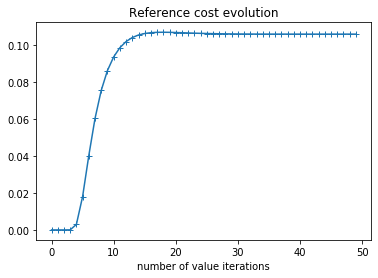

In [11]:
J, J_ref = dpsolv.eval_policy(pol_ini, 50, rel_dp=True, J_ref_full=True)
plt.plot(J_ref, '-+')
plt.title('Reference cost evolution');
plt.xlabel('number of value iterations');

Conclusion : 50 time steps (i.e. 50 hours) is well enough for the cost to converge

**Step 3:** Run *Policy Iteration* algorithm

note: each iteration takes about 5 s (on a good Intel Core i7 laptop), mostly with the value iteration step.

In [12]:
# Number of policy iterations:
n_pol = 4

# Number of value iterations
#(inner loop used for policy evaluation)
n_val = 50

# run
J, pol = dpsolv.policy_iteration(pol_ini, 
                                 n_val, n_pol,
                                 rel_dp=True)

policy evaluation run in 0.06 s     
ref policy cost: 0.105724
policy iteration 1/4
value iteration run in 5.50 s
policy evaluation run in 0.06 s     
ref policy cost: 0.0486519
policy iteration 2/4
value iteration run in 5.21 s
policy evaluation run in 0.07 s     
ref policy cost: 0.0468464
policy iteration 3/4
value iteration run in 4.90 s
policy evaluation run in 0.06 s     
ref policy cost: 0.0468268
policy iteration 4/4
value iteration run in 4.89 s
policy evaluation run in 0.05 s     
ref policy cost: 0.0468268


Conclusion:

* convergence in only 3 step policy improvements
* significant cost improvement: 0.106 → 0.047

## Plot the energy manangement policy

Plot the policy from the viewpoing of $P_{dev}$, the deviation from the grid commitment.

From the control optimization, we can extract the optimal law $P_{dev}^*(E_{rated}, P_{mis})$ as a 2D array:

In [13]:
pol_sto = pol[..., 0]
pol_dev = P_mis_grid - pol_sto
pol_dev.shape

(41, 61)

Colormap for the plot: Cynthia Brewer's [RdBu colormap](http://colorbrewer2.org/?type=diverging&scheme=RdBu&n=11) (reversed so that negative values are blue, positive values are red)

In [14]:
cm_blred = mpl.cm.RdBu_r
# Test:
cm_blred([0, 0.5, 1]) # → blue, white, red

array([[0.01960784, 0.18823529, 0.38039216, 1.        ],
       [0.96908881, 0.96647443, 0.96493656, 1.        ],
       [0.40392157, 0.        , 0.12156863, 1.        ]])

### 3D plot of the policy

In [15]:
from mpl_toolkits.mplot3d import Axes3D
surf_opts = dict(rstride=3, cstride=3,
                 vmin=-p_mis_max, vmax=p_mis_max,
                 cmap=cm_blred, edgecolor=(0,0,0,0.2))
azim = -20
P_mis_label = 'Mismatch $P_{mis}$ (MW)'
E_sto_label = 'Energy $E_{sto}$ (MWh)'

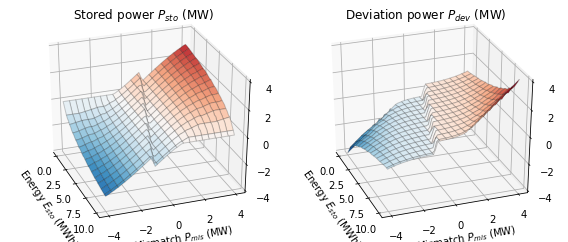

In [16]:
fig = plt.figure(figsize=(8,3.5))
ax1 = fig.add_subplot(121, projection='3d',
                          title='Stored power $P_{sto}$ (MW)',
                          xlabel=E_sto_label, ylabel=P_mis_label,
                          )
ax1.plot_surface(E_sto_grid, P_mis_grid, pol_sto, **surf_opts)
ax1.locator_params(nbins=5)
ax1.set_zlim(-p_mis_max, p_mis_max)
ax1.view_init(30, azim)

ax2 = fig.add_subplot(122, projection='3d',
                          title='Deviation power $P_{dev}$ (MW)',
                          xlabel=E_sto_label, ylabel=P_mis_label
                      )
ax2.plot_surface(E_sto_grid, P_mis_grid, pol_dev, **surf_opts)
ax2.locator_params(nbins=5)
ax2.set_zlim(-p_mis_max, p_mis_max)
ax2.view_init(30, azim)

fig.tight_layout()

### 2D plot of the policy

In [17]:
im_opts = dict(interpolation='nearest', cmap = cm_blred,
                   extent=(-p_mis_max, p_mis_max, 0, E_rated),
                   vmin=-P_rated, vmax=P_rated,
                   origin='lower', aspect='auto')
P_mis_label = 'Production mismatch $P_{mis}$ (MW)'
E_sto_label = 'Storage energy $E_{sto}$ (MWh)'

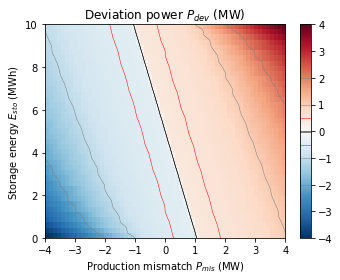

In [18]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, title='Deviation power $P_{dev}$ (MW)',
                          xlabel=P_mis_label, ylabel=E_sto_label)
im = ax.imshow(pol_dev,  **im_opts)
cbar = fig.colorbar(im, ticks=mpl.ticker.MultipleLocator())
# contours
clines = ax.contour(P_mis_grid, E_sto_grid, pol_dev,
                [-1e-2, 1e-2],
                colors='k', linestyles='solid', linewidths=.5)
cbar.add_lines(clines)
clines2 = ax.contour(P_mis_grid, E_sto_grid, pol_dev, [-2,-1,1,2],
            colors='gray', linestyles='solid', linewidths=.5)
cbar.add_lines(clines2, erase=False)

# tolerance power
clines_tol = ax.contour(P_mis_grid, E_sto_grid, pol_dev, [-P_tol, P_tol],
            colors='r', linestyles='solid', linewidths=.5)
cbar.add_lines(clines_tol, erase=False)

fig.tight_layout()

Next steps:

* simulate system trajectories using the optimized control, and
* evaluate the control performance using *real data* (for production mismatch $P_{mis}$